## Setup

In [1]:
import matplotlib.pyplot as plt
from skimage.filters import *
import imutils
import cv2
import numpy as np
import pytesseract
from functools import reduce
from operator import add

## Import image

In [100]:
src = cv2.imread("./images/test2.jpg")
src = cv2.cvtColor(src, cv2.COLOR_RGB2BGR)

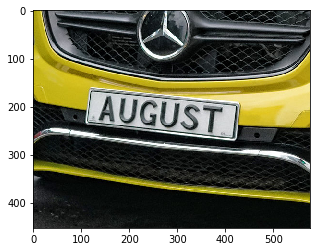

In [101]:
plt.imshow(src)
plt.show()

In [102]:
def automatic_brightness_and_contrast(image, clip_hist_percent=10):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)

    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))

    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0

    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1

    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1

    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha

    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return (auto_result, alpha, beta)

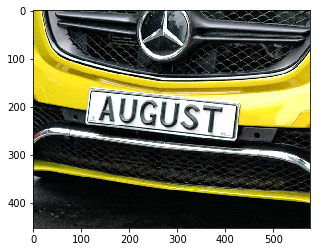

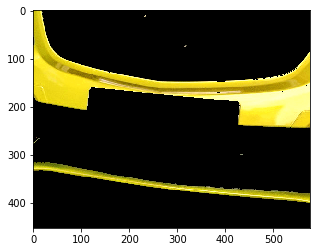

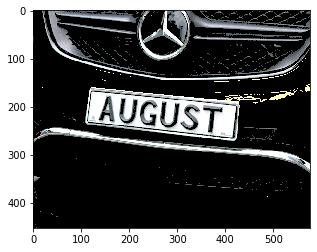

In [103]:
img_raw = src.copy()
auto_result, _, _ = automatic_brightness_and_contrast(img_raw)
plt.imshow(auto_result)
plt.show()
img_hsv = cv2.cvtColor(auto_result, cv2.COLOR_BGR2HSV)
# Yello threshold
lower_yellow = np.array([70, 50, 100])
upper_yellow = np.array([110, 255, 255])
# White threshold
lower_white = np.array([0, 0, 80])
upper_white = np.array([179, 70, 255])
img_color_thres_mask_yellow = cv2.inRange(img_hsv, lower_yellow, upper_yellow)
img_color_thres_mask_white = cv2.inRange(img_hsv, lower_white, upper_white)
img_color_thres_yellow = cv2.cvtColor(cv2.bitwise_and(img_hsv, img_hsv, mask=img_color_thres_mask_yellow), cv2.COLOR_HSV2BGR)
img_color_thres_white= cv2.cvtColor(cv2.bitwise_and(img_hsv, img_hsv, mask=img_color_thres_mask_white), cv2.COLOR_HSV2BGR)
plt.imshow(img_color_thres_yellow)
plt.show()
plt.imshow(img_color_thres_white)
plt.show()

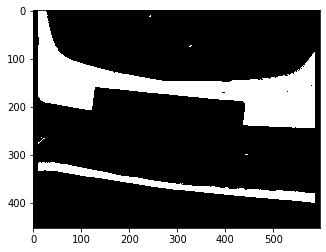

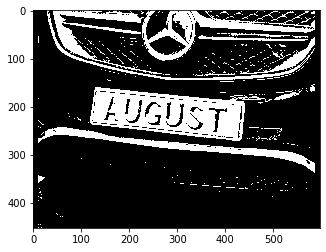

50379

In [104]:
def binarify(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    threshold = threshold_minimum(image)
    binary_image = (image > threshold).astype(np.uint8)
    binary_image = cv2.copyMakeBorder(binary_image, 0, 0, 10, 10, cv2.BORDER_CONSTANT, 0)
    plt.imshow(binary_image, cmap = 'gray')
    plt.show()
    return binary_image

binary_yellow = binarify(img_color_thres_yellow)
binary_white = binarify(img_color_thres_white)
np.count_nonzero(binary_yellow)

In [105]:
contours_white, _ = cv2.findContours(binary_white, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contours_yellow, _ = cv2.findContours(binary_yellow, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contours_white = [c for c in contours_white if cv2.contourArea(c) > 50]
contours_yellow = [c for c in contours_yellow if cv2.contourArea(c) > 50]

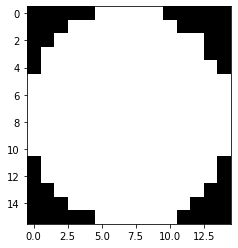

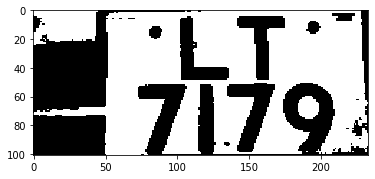

7ET10


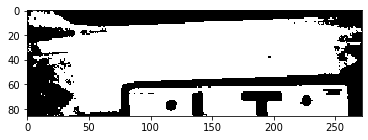

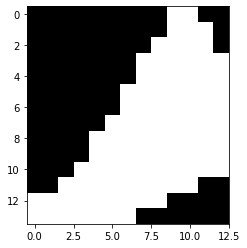

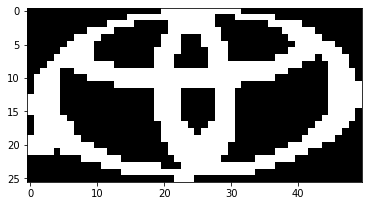

SO


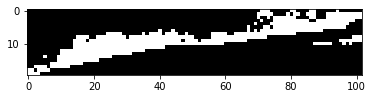

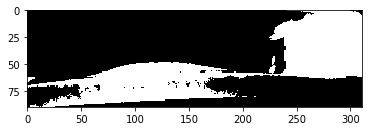

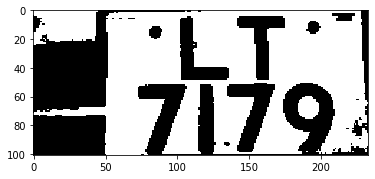

License plate: 7ET10


In [99]:
ocr_dict = {}

for contour in contours_yellow:
    x,y,w,h = cv2.boundingRect(contour)
    cropped_image = binary_yellow[y:y+h, x:x+w]
    text = pytesseract.image_to_string(cropped_image, lang='eng', config='-c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 --psm 6')
    ocr_dict[text] = cropped_image
    plt.imshow(cropped_image, cmap='gray')
    plt.show()
    print(text)
    
for contour in contours_white:
    x,y,w,h = cv2.boundingRect(contour)
    cropped_image = binary_white[y:y+h, x:x+w]
    text = ''.join(pytesseract.image_to_string(cropped_image, lang='eng', config='-c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 --psm 6').split())
    ocr_dict[text] = cropped_image
    plt.imshow(cropped_image, cmap='gray')
    plt.show()
    print(text)

license = max(ocr_dict.keys(), key=len)
plt.imshow(ocr_dict[license], cmap='gray')
plt.show()
print("License plate: {}".format(''.join(license.split())))